In [1]:
import glob
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
# import cv2
from keras.preprocessing.image import ImageDataGenerator

In [2]:
tf.__version__

'2.6.0'

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    print(e)

In [4]:
train_datagen = ImageDataGenerator(rotation_range=90,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   validation_split=0.2
                                   )

test_datagen = ImageDataGenerator(validation_split=0.2)

valid_datagen = ImageDataGenerator(validation_split=0.5)

In [5]:
disease_name = input('원하는 질병 이름을 입력하세요: ')
animal = input('동물 종류 (개 or 고양이): ')

In [6]:
data_dir = '1.Training/라벨링데이터/' + animal + '/안구/일반/' + disease_name

In [7]:
input_shape = 224

In [8]:
train_generator = train_datagen.flow_from_directory(data_dir,
                                                    target_size = (input_shape,input_shape),
                                                    batch_size=32,
                                                    class_mode='sparse',
                                                    seed=42,
                                                    subset='training')

test_generator = test_datagen.flow_from_directory(data_dir,
                                                  target_size=(input_shape,input_shape),
                                                  batch_size=32,
                                                  class_mode='sparse',
                                                  seed=42,
                                                  subset='validation')

Found 22023 images belonging to 4 classes.
Found 5504 images belonging to 4 classes.


In [9]:
labels = (train_generator.class_indices)
n_classes = len(labels)
labels

{'무': 0, '비성숙': 1, '성숙': 2, '초기': 3}

In [10]:
model = tf.keras.models.load_model('개_백내장_DenseNet.h5')

In [10]:
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

# Load the pre-trained DenseNet121 model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(input_shape, input_shape, 3))

# Add a GlobalAveragePooling2D layer to reduce the spatial dimensions
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer with a single output for binary classification
x = Dense(n_classes, activation='softmax')(x)

# Create the final model by attaching the binary classification head to the base model
model = Model(inputs=base_model.input, outputs=x)

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
               
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

saved_model = animal + '_' + disease_name + '_DenseNet_100epoch.h5'

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10,restore_best_weights=True)
mc = tf.keras.callbacks.ModelCheckpoint(saved_model, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [17]:
history = model.fit(train_generator,
          epochs=50,
          validation_data=test_generator,
        #   steps_per_epoch=len(train_generator),
        #   validation_steps=len(test_generator),
          callbacks=[es, mc]
          )

Epoch 1/50
689/689 [==============================] - 178s 247ms/step - loss: 0.1172 - accuracy: 0.9558 - val_loss: 0.2686 - val_accuracy: 0.9139

Epoch 00001: val_accuracy improved from -inf to 0.91388, saving model to 개_백내장_DenseNet_100epoch.h5
Epoch 2/50
689/689 [==============================] - 169s 246ms/step - loss: 0.1246 - accuracy: 0.9529 - val_loss: 0.2703 - val_accuracy: 0.9139

Epoch 00002: val_accuracy did not improve from 0.91388
Epoch 3/50
689/689 [==============================] - 169s 244ms/step - loss: 0.1232 - accuracy: 0.9544 - val_loss: 0.2678 - val_accuracy: 0.9133

Epoch 00003: val_accuracy did not improve from 0.91388
Epoch 4/50
689/689 [==============================] - 169s 246ms/step - loss: 0.1177 - accuracy: 0.9540 - val_loss: 0.2680 - val_accuracy: 0.9137

Epoch 00004: val_accuracy did not improve from 0.91388
Epoch 5/50
689/689 [==============================] - 169s 245ms/step - loss: 0.1178 - accuracy: 0.9552 - val_loss: 0.2688 - val_accuracy: 0.9133



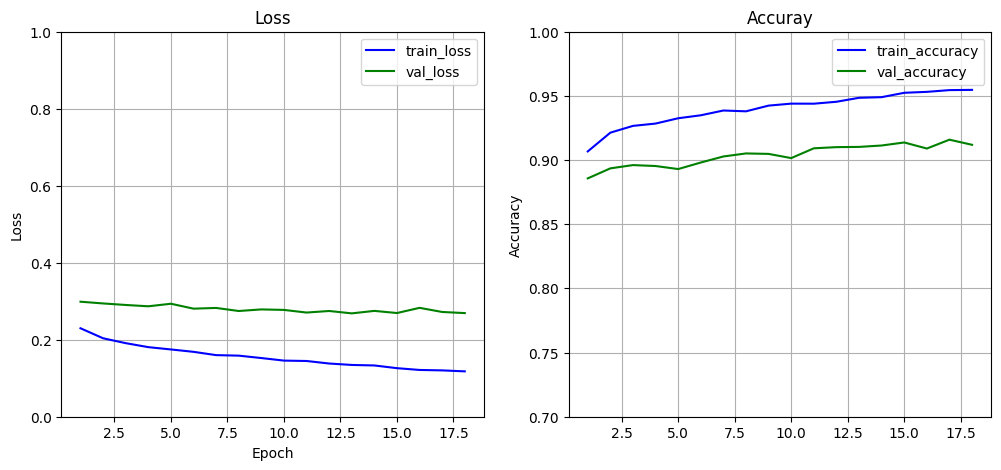

In [13]:
import matplotlib.pyplot as plt

loss = history.history['loss']
epochs = range(1, len(loss)+1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(epochs, history.history['loss'], 'b', label='train_loss')
plt.plot(epochs, history.history['val_loss'], 'g', label='val_loss')
plt.ylim([0,1.0])
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.title('Accuray')
plt.plot(epochs, history.history['accuracy'], 'b', label='train_accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'g', label='val_accuracy')
plt.ylim([0.7,1])
plt.grid(True)
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()